# Linear Regression, Part 1

In this notebook, we'll review the big ideas behind **linear regression**. 

Linear regression involves a **target variable** (also called the **dependent variable**) and some number of **explanatory variables** (also known as **independent variables** or **predictors**). We want to estimate the effect of the explanatory variables on the **mean** of the target variable, allowing us to understand how changes in the predictors influence the outcome.

For this notebook, we'll be using the [possum dataset](https://www.openintro.org/data/index.php?data=possum) from the OpenIntro Statistics textbook. We'll be using the total length (total_l) variable as our target.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
possums = pd.read_csv("../data/possum.csv")
possums.head()

,site,pop,sex,age,head_l,skull_w,total_l,tail_l
0,1,Vic,m,8.0,94.1,60.4,89.0,36.0
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0
3,1,Vic,f,6.0,93.2,57.1,92.0,38.0
4,1,Vic,f,2.0,91.5,56.3,85.5,36.0


Let's start by using the tail length (tail_l) as our predictor variable.

For linear regression, we assume that the mean value of the total length can be estimated using a linear function of the predictor variables:

$$Mean(total_l) = \beta_0 + \beta_1(tail_l)$$

To see if this looks plausible, let's inspect a scatterplot.

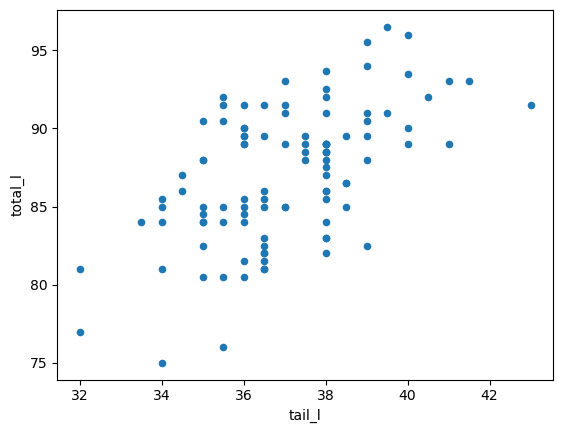

In [3]:
possums.plot(kind="scatter", x="tail_l", y="total_l");

**Question:** Does the model above look reasonable?

Now, we need to estimate the values of the coefficients, $\beta_0$ and $\beta_1$. For this, we'll use the statsmodels library.

In [4]:
import statsmodels.formula.api as smf

To specify our model, we need to use a [patsy formula](https://patsy.readthedocs.io/en/latest/formulas.html). The recipe is `target variable ~ predictor variables`.

We'll use the `ols` function and go ahead and fit the model.

In [5]:
lr_total_tail = smf.ols("total_l ~ tail_l", data=possums).fit()

To see the results, we can inspect the params.

In [6]:
lr_total_tail.params

Intercept    41.037130
tail_l        1.244307
dtype: float64

Substituting these estimates into the model, we get

$$Mean(total_l) = 41.037130 + 1.244307(tail_l)$$

**Question:** How do we interpret the meaning of the coefficint for the tail length (if tail length and total length are measured in cm)?

If we want to overlay the estimates on the scatterplot, we can use the predict method. We need to provide a DataFrame that has the correct columns.

In [7]:
pred_df = pd.DataFrame(
    {
        'tail_l': np.linspace(start=possums['tail_l'].min(), stop=possums['tail_l'].max())
    }
)

pred_df['mean_estimate'] = lr_total_tail.predict(pred_df)

pred_df.head(2)

,tail_l,mean_estimate
0,32.00000,80.854961
1,32.22449,81.134295


Let's verify the first estimate.

In [8]:
tail_l = 32
estimate = lr_total_tail.params['Intercept'] + lr_total_tail.params['tail_l']*tail_l
estimate

80.85496097833756

Now, let's plot the estimates with the original dataset.

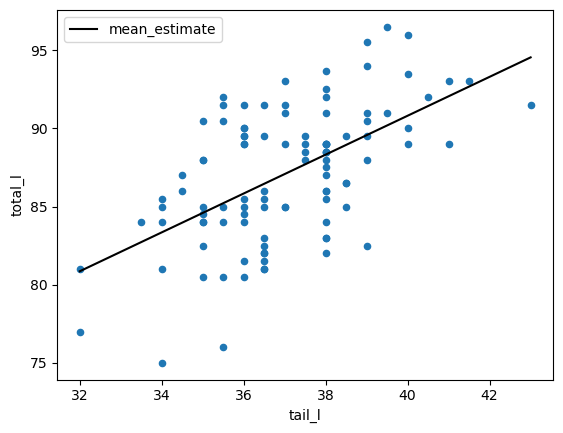

In [9]:
fig, ax = plt.subplots()
possums.plot(kind="scatter", x="tail_l", y="total_l", ax=ax)
pred_df.plot(kind="line", x="tail_l", y="mean_estimate", color="black", ax=ax);

### Inference for Linear Regression

At this point, it is important to remember that the coefficients that we got are merely **estimates**, which means that there is inherent **uncertainty** in those values. 

A common way to quantify this uncertainty is through a **confidence interval**, which gives a plausible range of values for the estimated parameters, given the observed data.

We can view the confidence interval for the estimates by inspecting the model summary output.

In [10]:
lr_total_tail.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                total_l   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     47.99
Date:                Thu, 17 Oct 2024   Prob (F-statistic):           3.94e-10
Time:                        21:07:05   Log-Likelihood:                -278.97
No. Observations:                 104   AIC:                             561.9
Df Residuals:                     102   BIC:                             567.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.0371      6.657      6.165      0.000      27.833      54.241
tail_l         1.2443      0.180      6.927      0.000       0.888       1.601
==============================================================================
Omnibus:                        1.679   Durbin-Watson:                   0.936
Prob(Omnibus):                  0.432   Jarque-Bera (JB):                1.488
Skew:                          -0.157   Prob(JB):                        0.475
Kurtosis:                       2.505   Cond. No.                         705.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This says that, given the observed data, it is plausible that the effect of a one-unit change in tail_l could be as small as 0.888 or as large as 1.601.

We might also ask whether the effect of tail_l is **statistically significant** or is the observed effect could be attributed solely to random **sampling error**.

This can be done either by checking whether the confidence interval contains 0 or by inspecting the p-value associated with tail_l. Since the p-value is small, we can conclude that the effect is statistically significant.

### Assumptions of Linear Regression

In order to rely on the confidence interval and p-values, we do need to check the assumptions of linear regression. 

The assumptions can be remembered using the acronym LINE:

* There is a **L**inear relationship between the predictors and mean of the target.
* The errors are **I**ndependent.
* The errors are **N**ormally distributed.
* The errors have **E**qual variance.

The first one we can check by inspecting the scatterplot of the predictors against the target variable.

The second assumption as more to do with understanding the data generation process. In this case, if we assume that we are working with a simple random sample, we can feel good that it is satisfied.

For the third and fourth, we can inspect a plot of the errors.

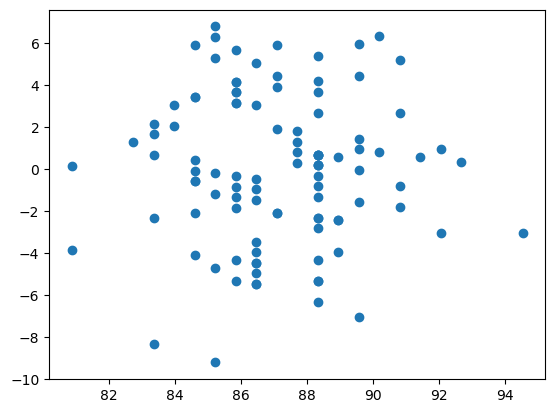

In [11]:
plt.scatter(lr_total_tail.fittedvalues, lr_total_tail.resid);

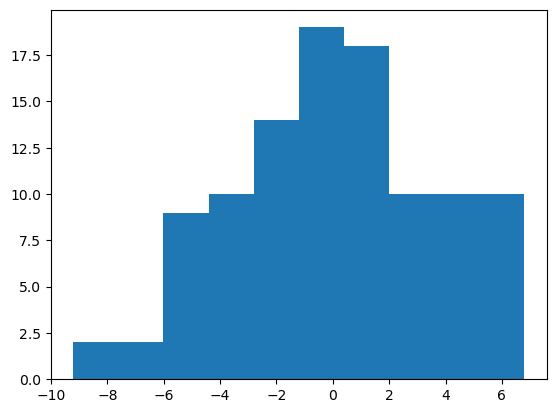

In [12]:
plt.hist(lr_total_tail.resid);

In [13]:
import statsmodels.stats.api as sms

To test for normality, we'll use the [Jarque-Bera test](https://www.statsmodels.org/dev/generated/statsmodels.stats.stattools.jarque_bera.html).

The Jarque-Bera test statistic tests the null that the data is normally distributed against an alternative that the data follow some other distribution.

In [14]:
sms.jarque_bera(lr_total_tail.resid)

(1.4879463321451836,
 0.47522202358833565,
 -0.15719094353814872,
 2.505493923623391)

The second component is the p-value. In this case, there is not enough evidence to conclude that the residuals are non-normal.

To test that there is equal variability in the residuals, we can use the [Breusch-Pagan Lagrange Multiplier test](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_breuschpagan.html) for heteroscedasticity which tests the hypothesis that the residual variance does not depend on the predictor variables.

In [15]:
sms.het_breuschpagan(lr_total_tail.resid, lr_total_tail.model.exog)

(1.2833100363788184, 0.257284496039655, 1.2743559372580988, 0.2615991382513874)

### Goodness of Fit

Another way we can analyze our model is by looking at the **goodness of fit** or how well the model's predicted values matched the observed data.

One way we can measure this is the **R-squared** value, which compares the variance of the residuals to the variance in the target variable. It is the proportion by which the variability in the target is reduced by using the estimate from the model. It is often phrased as the proportion of the variability in the target that could be **explained** by the predictor variables.

We can calculate it ourselves:

In [16]:
possums['total_l'].var()

18.580836445108282

In [17]:
lr_total_tail.resid.var()

12.635807928869479

In [18]:
(possums['total_l'].var() - lr_total_tail.resid.var()) / possums['total_l'].var()

0.31995483808286423

Or by inspecting the rsquared attribute.

In [19]:
lr_total_tail.rsquared

0.31995483808286485

A model that has no residuals would have an R-squared value of 1 and a model which estimates using the overall mean would have an R-squared value of 0.